# Preparation:

In [1]:
!pip install kaggle lightgbm statsmodels imblearn catboost xgboost --quiet


[notice] A new release of pip available: 22.3.1 -> 23.0.1
[notice] To update, run: pip install --upgrade pip


Imports

In [1]:
import pandas as pd
import os
import warnings
from sklearn.cluster import KMeans
import numpy as np
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor, GradientBoostingClassifier
from sklearn.model_selection import train_test_split
import lightgbm as lgb
import statsmodels.api as sm
from sklearn.metrics import make_scorer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from sklearn import metrics
from imblearn.over_sampling import SMOTE
from imblearn.ensemble import BalancedRandomForestClassifier 
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression
from matplotlib import pyplot as plt
from tqdm import tqdm
from datetime import datetime, timedelta
from sklearn import cluster

Important: Here I am using a kaggle.json file which contains my Kaggle key, BUT this is done for pure convenience and all the datasets used in this work can be downloaded by hand from the provided links and all the code will work without issues. You can also add your kaggle.json file to the same directory as this notebook and all the datasets will be downloaded for you automatically. This file can be downloaded from the kaggle menu in your account.

In [2]:
warnings.filterwarnings('ignore')
if os.path.exists('kaggle.json'):
    key = open('kaggle.json').read() # This is a key which is available for every Kaggle user
    os.makedirs("/root/.kaggle", exist_ok=True)
    open('/root/.kaggle/kaggle.json', 'w').write(key);
    os.system('chmod 600 /root/.kaggle/kaggle.json')
else:
    print('WARNING: No kaggle.json file found. You need to add it to this folder or add the datasets yourself')

In [3]:
def download_dataset(zipname, dsname, csvname):
    if not os.path.exists(zipname):
        print("Downloading the dataset...")
        os.system('kaggle datasets download -d '+dsname)
    if os.path.exists(csvname):
        print("Found the csv file, skipping unzip")
    else:
        print('Unzipping...')
        os.system('unzip -n '+zipname)
    print('Success')

Part 1 dataset ( https://www.kaggle.com/datasets/imakash3011/customer-personality-analysis ):

In [4]:
download_dataset(
    'customer-personality-analysis.zip',
    'imakash3011/customer-personality-analysis',
    'marketing_campaign.csv'
)

Found the csv file, skipping unzip
Success


Part 2 dataset ( https://www.kaggle.com/datasets/mirichoi0218/insurance ):

In [5]:
download_dataset(
    'insurance.zip',
    'mirichoi0218/insurance',
    'insurance.csv'
)

Found the csv file, skipping unzip
Success


Part 3 dataset ( https://www.kaggle.com/datasets/themachineteacher/imbalanced-credit-scoring ):

In [6]:
download_dataset(
    'imbalanced-credit-scoring.zip',
    'themachineteacher/imbalanced-credit-scoring',
    'X_train (1).csv'
)

Found the csv file, skipping unzip
Success


In [7]:
figsize = (5,4)
seed = 1

# Part 1:

Unsupervised learning

In [8]:
df = pd.read_csv('marketing_campaign.csv', sep='\t').drop(columns='ID')
df.head()

,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,MntFruits,...,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response
0,1957,Graduation,Single,58138.0,0,0,04-09-2012,58,635,88,...,7,0,0,0,0,0,0,3,11,1
1,1954,Graduation,Single,46344.0,1,1,08-03-2014,38,11,1,...,5,0,0,0,0,0,0,3,11,0
2,1965,Graduation,Together,71613.0,0,0,21-08-2013,26,426,49,...,4,0,0,0,0,0,0,3,11,0
3,1984,Graduation,Together,26646.0,1,0,10-02-2014,26,11,4,...,6,0,0,0,0,0,0,3,11,0
4,1981,PhD,Married,58293.0,1,0,19-01-2014,94,173,43,...,5,0,0,0,0,0,0,3,11,0


In [9]:
# sns.pairplot(df[[i for i in df.columns if len(df[i].unique())>5]])

In [10]:
quantile = df.Income.quantile(.95)
quantile

84130.0

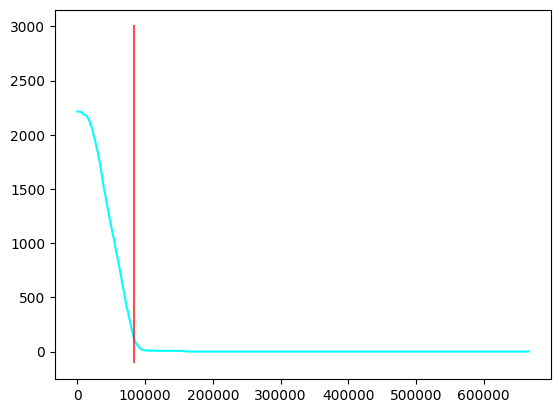

In [11]:
x = range(0, int(df.Income.max()), 1000)
y = tuple(np.sum(df.Income > i) for i in x)

plt.plot(x, y, color='cyan')
plt.plot((quantile, quantile), (-100, 3000), color='red', alpha=.7)
plt.show()

There are not a lot of incomes which are larger than the 95% quantile, and many of them are huge outliers, so we can cut them off to increase the quality of the data.

In [12]:
np.sum(df.Income > quantile)

111

In [13]:
df = df[df.Income < quantile]

In [14]:
df.dropna(inplace=True)

In [15]:
now = datetime.now().date()
df.Dt_Customer = df.Dt_Customer.apply(lambda x: (now-datetime.strptime(x, '%d-%m-%Y').date()).days )

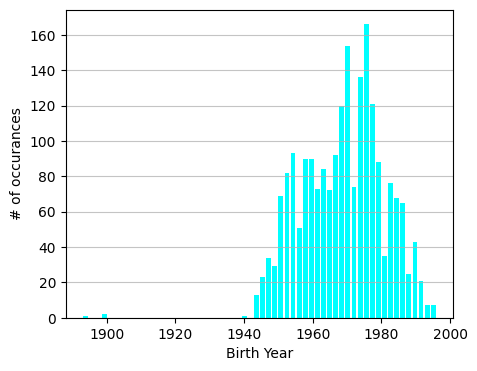

In [16]:
plt.figure(figsize=figsize)
plt.hist(df.Year_Birth, color='cyan', rwidth=.8, bins=len(df.Year_Birth.unique()))
plt.grid(axis='y', alpha=0.75)
plt.xlabel('Birth Year')
plt.ylabel('# of occurances')
plt.show()

In [17]:
np.sum(df.Year_Birth <= 1923)

3

There are some people in the dataset who are more than a 100 years old, probably not a genuine response, even if not, there are not many of those people and they should be considered outliers.

It should be noted that while there deleting such a small amount of outliers probably would not affect the predictive performance of the regular models, it can have a considerable affect on the clustering models, as outliers may form a cluster of their own and therefore rob us of useful information. 

In [18]:
df = df[df.Year_Birth > 1923]
df['age'] = datetime.now().year-df.Year_Birth
df.drop(columns='Year_Birth', inplace=True)

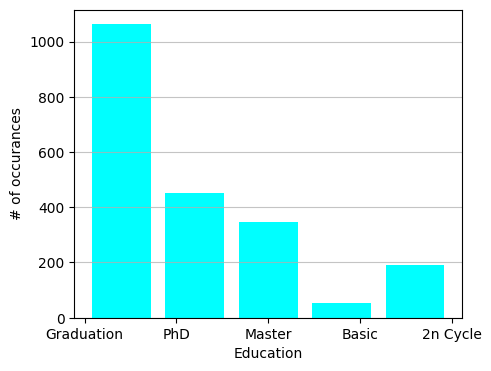

In [19]:
plt.figure(figsize=figsize)
plt.hist(df.Education, color='cyan', rwidth=.8, bins=len(df.Education.unique()))
plt.grid(axis='y', alpha=0.75)
plt.xlabel('Education')
plt.ylabel('# of occurances')
plt.show()

2n Cycle is a degree which is most likely an equivalent of Master education. Moreover, there are not too many observations of both, so combining them for the sake of dimensionality reduction makes sense.

In [20]:
df.Marital_Status = (df.Marital_Status == 'Together')*1

In [21]:
for i in df.Education.unique():
    if i == '2n Cycle': continue
    if i == 'Master Education':
        df['education_master'] = ((df.Education == 'Master Education') | (df.Education == '2n Cycle'))*1
        continue
    df[f'education_{i.lower()}'] = (df.Education == i)*1
df.drop(columns='Education', inplace=True)
df.head()

,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,...,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response,age,education_graduation,education_phd,education_master,education_basic
0,0,58138.0,0,0,3863,58,635,88,546,172,...,0,0,3,11,1,66,1,0,0,0
1,0,46344.0,1,1,3313,38,11,1,6,2,...,0,0,3,11,0,69,1,0,0,0
2,1,71613.0,0,0,3512,26,426,49,127,111,...,0,0,3,11,0,58,1,0,0,0
3,1,26646.0,1,0,3339,26,11,4,20,10,...,0,0,3,11,0,39,1,0,0,0
4,0,58293.0,1,0,3361,94,173,43,118,46,...,0,0,3,11,0,42,0,1,0,0


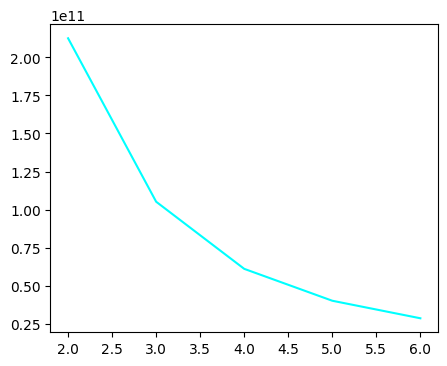

In [22]:
clust_range = range(2,7)
wss = []
for k in clust_range:
    kmeans=cluster.KMeans(n_clusters=k,init="k-means++")
    kmeans=kmeans.fit(df)
    wss_iter = kmeans.inertia_
    wss.append(wss_iter)
plt.figure(figsize=figsize)
plt.plot(clust_range, wss, color='cyan')
plt.show()

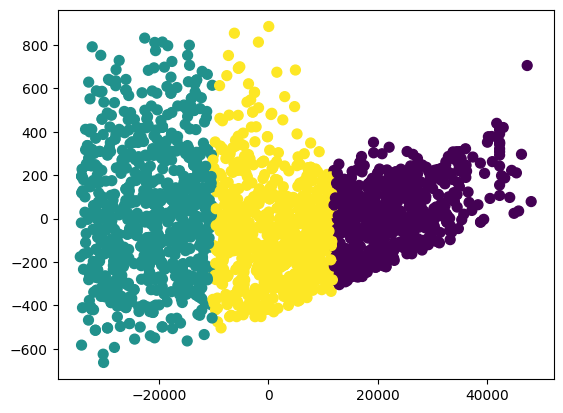

In [23]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Load the data
# df = pd.read_csv('data.csv')

# Calculate the principal components
pca = PCA(n_components=2)
principal_components = pca.fit_transform(df)

# Cluster the data
kmeans = KMeans(n_clusters=3)
labels = kmeans.fit_predict(principal_components)

# Plot the scatter plot
plt.scatter(principal_components[:, 0], principal_components[:, 1], c=labels, s=50)
plt.show()

In [24]:
n_clusters = 3

km = KMeans(n_clusters=n_clusters)
km.fit(df)

labels = km.labels_
colors = ['cyan', 'blue', 'magenta', 'green', 'orange', 'red']
lab_cols = [colors[i] for i in labels]

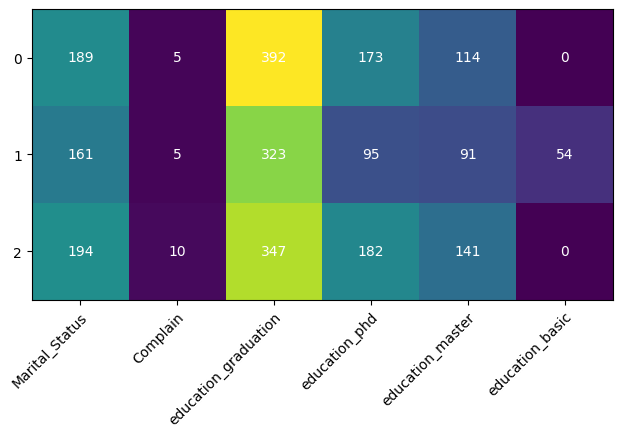

In [33]:
clusters = range(n_clusters)
columns = [i for i in df.columns if len(df[i].unique()) == 2 and i not in ['AcceptedCmp'+str(i) for i in range(1,6)]+['Response']]

observations = []
for cluster in clusters:
    row = []
    for column in columns:
        row.append(np.sum( (df[column] == 1) & (labels == cluster) ) )
    observations.append(row)
observations = np.array(observations)

def make_heatmap(clusters, columns, observations):
    fig, ax = plt.subplots()
    im = ax.imshow(observations)

    # Show all ticks and label them with the respective list entries
    ax.set_xticks(np.arange(len(columns)), labels=columns)
    ax.set_yticks(np.arange(len(clusters)), labels=clusters)

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
            rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    for i in range(len(clusters)):
        for j in range(len(columns)):
            text = ax.text(j, i, observations[i, j],
                        ha="center", va="center", color="w")

    # ax.set_title("")
    fig.tight_layout()
    plt.show()

make_heatmap(clusters, columns, observations)

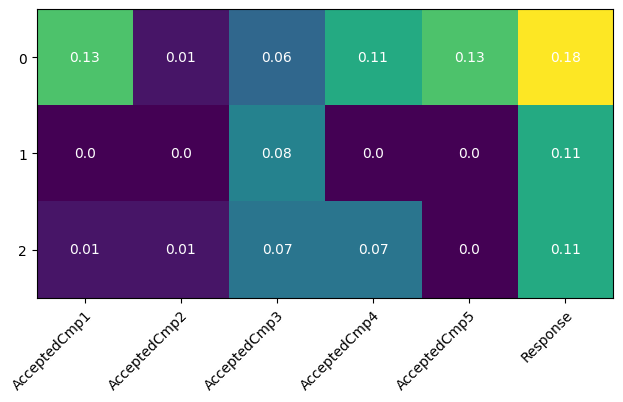

In [34]:
import matplotlib.pyplot as plt

clusters = range(n_clusters)
columns = ['AcceptedCmp'+str(i) for i in range(1,6)]+['Response']

observations = []
for cluster in clusters:
    row = []
    for column in columns:
        row.append( round(df[column][labels == cluster].mean(), 2) )
    observations.append(row)
observations = np.array(observations)

make_heatmap(clusters, columns, observations)

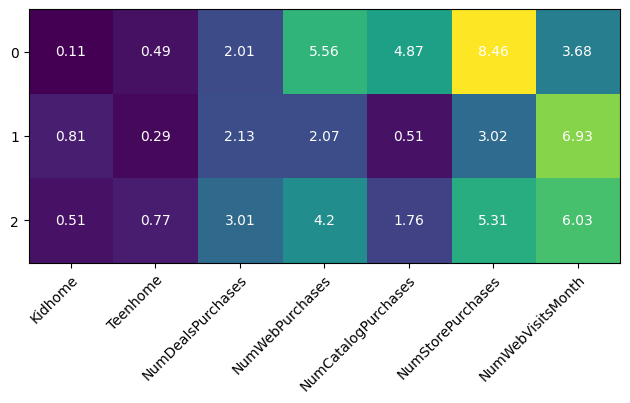

In [27]:
clusters = range(n_clusters)
columns = [i for i in df.columns if len(df[i].unique()) > 2 and i not in ('Income', 'Dt_Customer', 'MntWines','MntMeatProducts','Recency', 'MntGoldProds', 'age', 'MntFishProducts', 'MntFruits', 'MntSweetProducts')]

observations = []
for cluster in clusters:
    row = []
    for column in columns:
        row.append( round(df[column][labels == cluster].mean(), 2) )
    observations.append(row)
observations = np.array(observations)

# plt.rcParams.update({'font.size': 6})
make_heatmap(clusters, columns, observations)
# plt.rcParams.update(plt.rcParamsDefault)

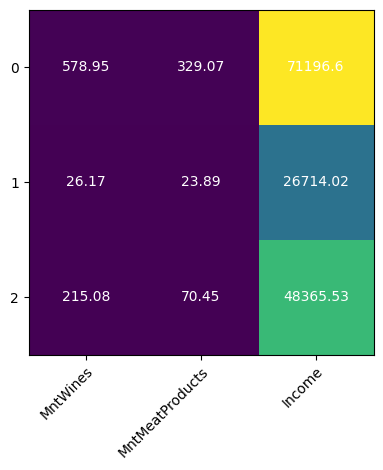

In [32]:
clusters = range(n_clusters)
columns = ['MntWines','MntMeatProducts', 'Income']

observations = []
for cluster in clusters:
    row = []
    for column in columns:
        row.append( round(df[column][labels == cluster].mean(), 2) )
    observations.append(row)
observations = np.array(observations)

make_heatmap(clusters, columns, observations)

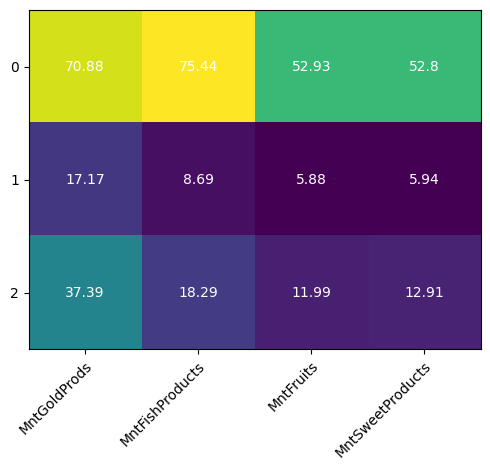

In [29]:
import matplotlib.pyplot as plt

clusters = range(n_clusters)
columns = ['MntGoldProds', 'MntFishProducts', 'MntFruits', 'MntSweetProducts']

observations = []
for cluster in clusters:
    row = []
    for column in columns:
        row.append( round(df[column][labels == cluster].mean(), 2) )
    observations.append(row)
observations = np.array(observations)

make_heatmap(clusters, columns, observations)

In [33]:
# for i in df.columns:
#     plt.figure(figsize=(4,3))
#     bar_heights = []
#     for j in range(n_clusters):
#         bar_heights.append(df[i][labels == j].mean())
#     plt.bar([f'mean c{i}' for i in range(n_clusters)], bar_heights, color='cyan')
#     plt.title(i)
#     plt.show()

In [34]:
# for i in range(len(df.columns)):
#     for j in range(i+1, len(df.columns)):
#         if len(df[df.columns[i]].unique()) < 5 or len(df[df.columns[j]].unique()) < 5: continue
#         plt.figure(figsize=(4,3))
#         plt.scatter(df[df.columns[i]], df[df.columns[j]], c=lab_cols)
#         plt.xlabel(df.columns[i])
#         plt.ylabel(df.columns[j])
#         plt.show()

# Part 2:

Regression

In [35]:
df = pd.read_csv('insurance.csv')
df.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


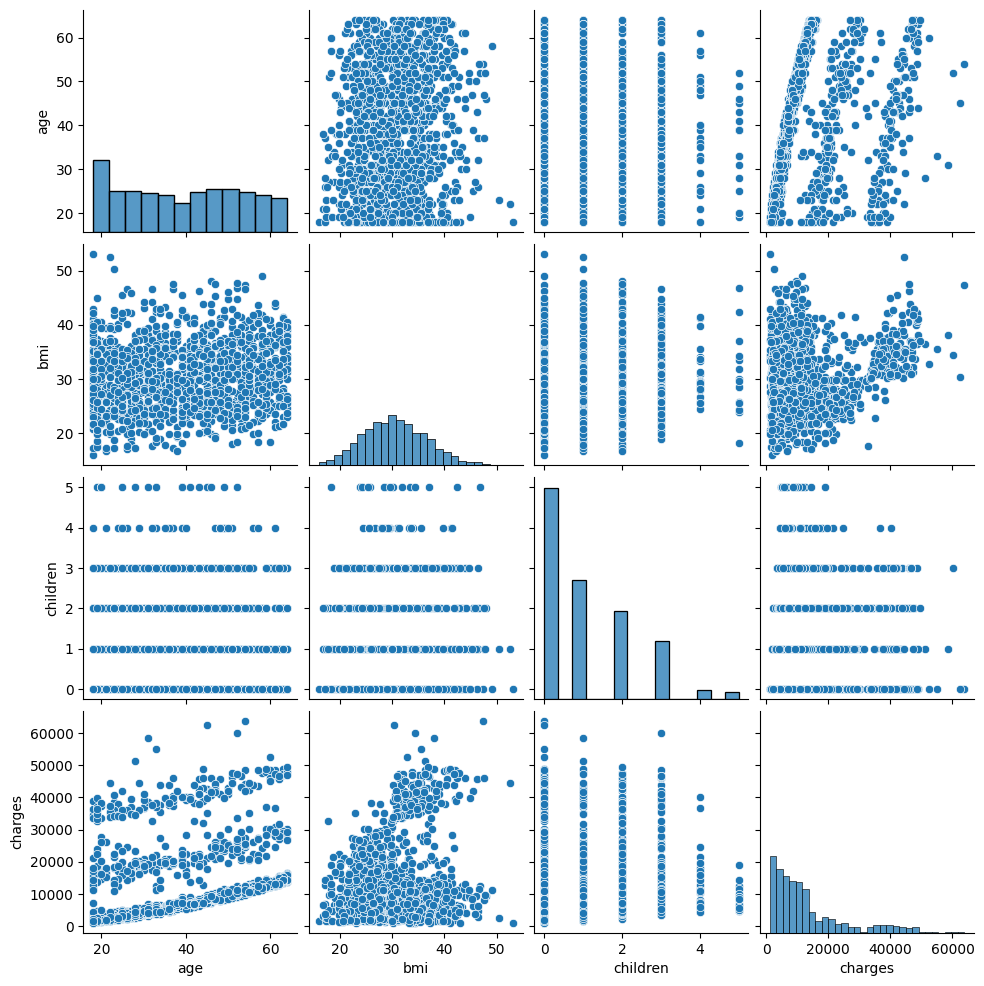

In [36]:
sns.pairplot(df)
plt.style.use('default')

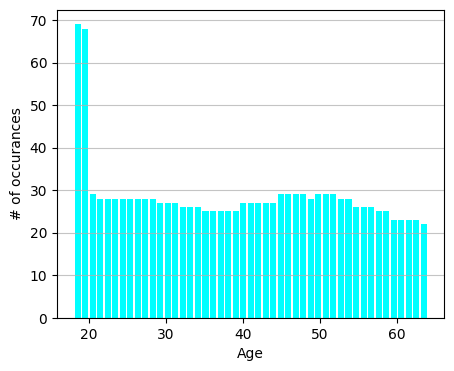

In [37]:
plt.figure(figsize=figsize)
plt.hist(df.age, color='cyan', rwidth=.8, bins=len(df.age.unique()))
plt.grid(axis='y', alpha=0.75)
plt.xlabel('Age')
plt.ylabel('# of occurances')
plt.show()

Ages are distributed equally except for ages below 20, which makes this dataset good in terms or representability

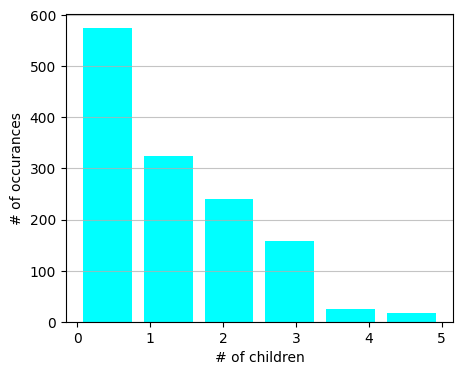

In [38]:
plt.figure(figsize=figsize)
plt.hist(df.children, color='cyan', rwidth=.8, bins=len(df.children.unique()))
plt.grid(axis='y', alpha=0.75)
plt.xlabel('# of children')
plt.ylabel('# of occurances')
plt.show()

We can see that there are almost no observations where the number of children is 4 or five, so it makes sense to combine them to reduce the dimensionality of the data. Also, from the pairplot we can see that there isn't much of a difference in charges for 4 and 5 children

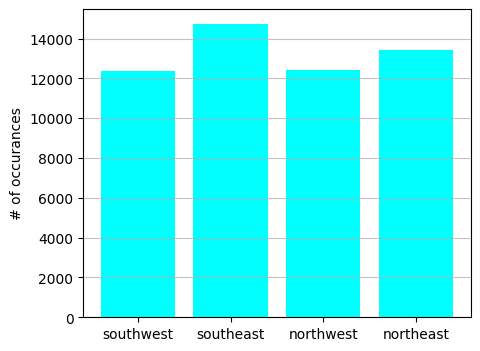

In [39]:
plt.figure(figsize=figsize)
uregs = df.region.unique()
plt.bar(uregs, [df.charges[df.region == i].mean() for i in uregs], color='cyan')
plt.grid(axis='y', alpha=0.75)
plt.ylabel('# of occurances')
plt.show()

Regions are represented equally, so no reason to modify these classes or worry about representability

In [40]:
df.smoker = (df.smoker == 'yes')*1
df.sex = (df.sex == 'male')*1

In [41]:
df['children'][df.children > 4] = 4

We can also add an interaction effect between "smoker" and "age" variables because people of old age who also smoke are double bad.

In [42]:
df['smoker'] = df.smoker*df.age

Splitting regions into categorial variables

In [43]:
for i in df.region.unique():
    df['region_'+i] = (df.region == i)*1
df.drop(columns='region', inplace=True)
df.head()

,age,sex,bmi,children,smoker,charges,region_southwest,region_southeast,region_northwest,region_northeast
0,19,0,27.900,0,19,16884.92400,1,0,0,0
1,18,1,33.770,1,0,1725.55230,0,1,0,0
2,28,1,33.000,3,0,4449.46200,0,1,0,0
3,33,1,22.705,0,0,21984.47061,0,0,1,0
4,32,1,28.880,0,0,3866.85520,0,0,1,0


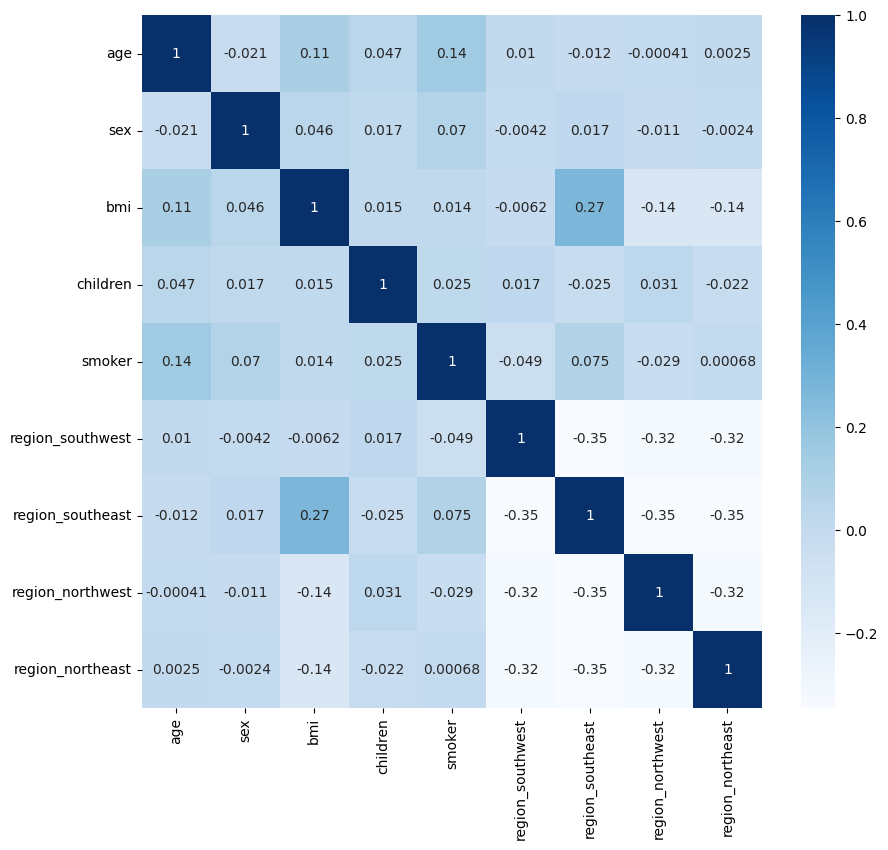

In [44]:
corr = df.drop(columns='charges').corr()
plt.figure(figsize=(10,9))
sns.heatmap(corr, cmap="Blues",annot=True)
plt.show()

There are no meaningful correlations between variables which means that based on this plot alone we cannot think of excluding any variables.

In [45]:
x_train, x_test, y_train, y_test = train_test_split(df.drop(columns=['charges']), 
    df.charges, test_size=0.3, random_state=seed)
# quan = y_train.quantile(0.95)
# cond = y_train < quan
# x_train = x_train[cond]
# y_train = y_train[cond]
# quan = x_train["bmi"].quantile(0.95)
# cond = x_train.bmi < quan
# x_train = x_train[cond]
# y_train = y_train[cond]

100%|██████████| 8/8 [01:38<00:00, 12.36s/it]


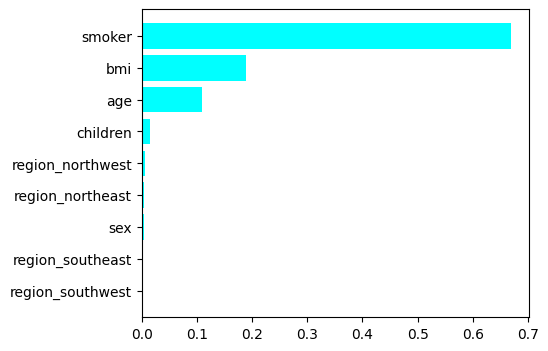

In [46]:
# def MAE(y_true, y_pred):
#     pred = pd.DataFrame({'pred': y_pred, 'true': y_true})
#     print(np.abs(pred.y_true-pred.y_pred))
#     result = np.sum( np.abs(pred.y_true-pred.y_pred) )/len(pred)
#     return result
# MAE = make_scorer(MAE, greater_is_better=False)

best_mae, best_n_est, best_max_depth, best_rf = np.inf, None, None, None
for n_est in tqdm(range(100, 500, 50)):
    for max_depth in range(3, 20, 5):
        rf = RandomForestRegressor(n_estimators=n_est, max_depth=max_depth)
        # rf.fit(x_train, y_train)
        # pred = rf.predict(x_test)
        mae = -np.mean(cross_val_score(rf, x_train, y_train, cv=5, scoring='neg_mean_absolute_error'))

        # mae = np.sum( np.abs(y_test-pred) )/len(pred)
        if mae < best_mae:
            best_mae = mae
            best_n_est = n_est
            best_max_depth = max_depth
            best_rf = rf
best_rf = best_rf.fit(x_train, y_train)
plt.figure(figsize=figsize)
order = best_rf.feature_importances_.argsort()
plt.barh(x_train.columns[order], best_rf.feature_importances_[order], color='cyan')
plt.show()

We can see that Random Forest deems "smoker" variable the most important, which makes sense because "charges" in our dataset are based on Individual medical costs billed by health insurance, and smokers generally receive worse rates for insurance because they have higher health risks. The same can be said about the BMI and age. People who are obese run higher risks of heart issues, people who are too skinny - malnutrition, osteoporosis, decreased muscle strength, hypothermia and lowered immunity. When aging people also become more susceptible to illnesses and suffer from them in more severe forms, many illnesses are also associated with aging, meaning that such a people will spend more money on their health, therefore, insurance for them is generally considerably higher.

In [47]:
print(f'Best random forest contains {best_n_est} estimators and has max depth of {best_max_depth}')
print('MAE:', best_mae)

Best random forest contains 400 estimators and has max depth of 8
MAE: 2716.275760153502


Pretty good, but we saw in the feature importance plot that regions don't have much meaning for the random forest. Therefore we will now try to drop them to potentially make the forest focus on more important features.

MAE: 2667.583081606441


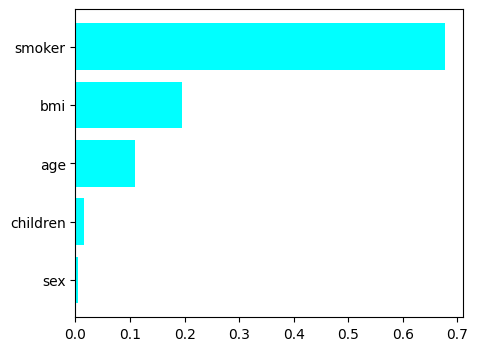

In [48]:
rf = RandomForestRegressor(n_estimators=best_n_est, max_depth=best_max_depth)
region_cols = [i for i in df.columns if 'region' in i]
rf.fit(x_train.drop(columns=region_cols), y_train)
pred = rf.predict(x_test.drop(columns=region_cols))
mae = np.sum( np.abs(y_test-pred) )/len(pred)
print('MAE:', mae)
plt.figure(figsize=figsize)
order = rf.feature_importances_.argsort()
plt.barh(x_train.columns[order], rf.feature_importances_[order], color='cyan')
plt.show()

the plan was a success, MAE has improved.

Now, let's try applying another algorithm to this data. We will also try using bootstrap *insert generic benefits of bootstrap here*. 

In [49]:
x_train['y_train'] = y_train
x_train = x_train.sample(int(len(x_train)*1.5), replace=True, random_state = 0).drop(columns=region_cols)
y_train = x_train['y_train']
x_train = x_train.drop(columns = 'y_train')

In [50]:
params = {
    'task': 'train', 
    'boosting': 'gbdt',
    'objective': 'regression',
    'num_leaves': 10,
    'metric': {'l2','l1'},
    'verbose': -1
}
 
lgb_train = lgb.Dataset(x_train, y_train)
lgb_test = lgb.Dataset(x_test.drop(columns=region_cols), y_test, reference=lgb_train)

model = lgb.train(params,
                 train_set=lgb_train,
                 valid_sets=lgb_test,
                 early_stopping_rounds=30)

[1]	valid_0's l1: 8159.48	valid_0's l2: 1.1891e+08
Training until validation scores don't improve for 30 rounds
[2]	valid_0's l1: 7503.8	valid_0's l2: 1.00184e+08
[3]	valid_0's l1: 6914.82	valid_0's l2: 8.51696e+07
[4]	valid_0's l1: 6395.07	valid_0's l2: 7.2811e+07
[5]	valid_0's l1: 5934.95	valid_0's l2: 6.29211e+07
[6]	valid_0's l1: 5511.55	valid_0's l2: 5.48979e+07
[7]	valid_0's l1: 5126.92	valid_0's l2: 4.82706e+07
[8]	valid_0's l1: 4778.8	valid_0's l2: 4.28247e+07
[9]	valid_0's l1: 4474.13	valid_0's l2: 3.85736e+07
[10]	valid_0's l1: 4197.93	valid_0's l2: 3.50387e+07
[11]	valid_0's l1: 3962.13	valid_0's l2: 3.22316e+07
[12]	valid_0's l1: 3736.86	valid_0's l2: 2.9765e+07
[13]	valid_0's l1: 3558.3	valid_0's l2: 2.79899e+07
[14]	valid_0's l1: 3396.63	valid_0's l2: 2.64623e+07
[15]	valid_0's l1: 3240.48	valid_0's l2: 2.51274e+07
[16]	valid_0's l1: 3109.41	valid_0's l2: 2.41387e+07
[17]	valid_0's l1: 2993.63	valid_0's l2: 2.33617e+07
[18]	valid_0's l1: 2884.29	valid_0's l2: 2.2595e+07
[

In [51]:
pred = model.predict(x_test.drop(columns=region_cols))
mae = np.sum( np.abs(y_test-pred) )/len(pred)
print('MAE:', mae)

MAE: 2254.8707291562996


Great success, MAE ebeishiy

In [52]:
# mse = np.sum( (y_test-pred)**2 )/len(pred)
# print('mse:', mse)

In [54]:
# 1/0
#lgbt: 2254.8707291562996
#rf: 3019.3018122083713

# Part 3:

Classification

In [55]:
x_train = pd.read_csv("X_train (1).csv")
y_train = pd.read_csv("y_train (1).csv")
x_train['y'] = y_train.target
x_train = x_train[~(x_train.age == 0)]
x_train.head()

,credit_card_utilization,age,overdue_30_59_days,debt_to_income,monthly_income,credits_loans,overdue__more_than_90_days,mortgage_loans,overdue_60_89_days,family_members,y
0,0.000000,56,0,0.504328,6823.894458,9,0,1,0,5.0,0
1,0.170659,45,1,2.405860,356.580765,5,0,0,0,0.0,0
2,0.342176,75,1,0.445066,20349.895825,9,0,3,0,0.0,0
3,0.046219,50,0,0.814508,2894.368968,12,0,1,0,3.0,0
4,0.679556,58,0,0.390311,24833.227614,15,0,4,0,2.0,0


In [56]:
des = x_train.describe()
des = des.append(pd.Series(data={ _:np.sum(np.isnan(x_train[_])) for _ in x_train.columns}, name='nans'), ignore_index= False)
des

,credit_card_utilization,age,overdue_30_59_days,debt_to_income,monthly_income,credits_loans,overdue__more_than_90_days,mortgage_loans,overdue_60_89_days,family_members,y
count,105108.000000,105108.000000,105108.000000,105108.000000,8.411500e+04,105108.000000,105108.000000,105108.000000,105108.000000,102303.000000,105108.000000
mean,5.825221,53.321574,0.426637,354.191521,6.649734e+03,8.956283,0.269970,1.018505,0.244358,0.757084,0.066893
std,251.022624,14.810164,4.251245,1827.192531,1.106510e+04,5.182731,4.227386,1.136230,4.214038,1.116524,0.249838
min,0.000000,21.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.029591,42.000000,0.000000,0.173668,3.343188e+03,5.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.153790,53.000000,0.000000,0.365038,5.361671e+03,8.000000,0.000000,1.000000,0.000000,0.000000,0.000000
75%,0.554344,64.000000,0.000000,0.880885,8.207870e+03,12.000000,0.000000,2.000000,0.000000,1.000000,0.000000
max,48779.730023,111.000000,98.000000,323248.210242,1.359526e+06,58.000000,98.000000,54.000000,98.000000,20.000000,1.000000
nans,0.000000,0.000000,0.000000,0.000000,2.099300e+04,0.000000,0.000000,0.000000,0.000000,2805.000000,0.000000


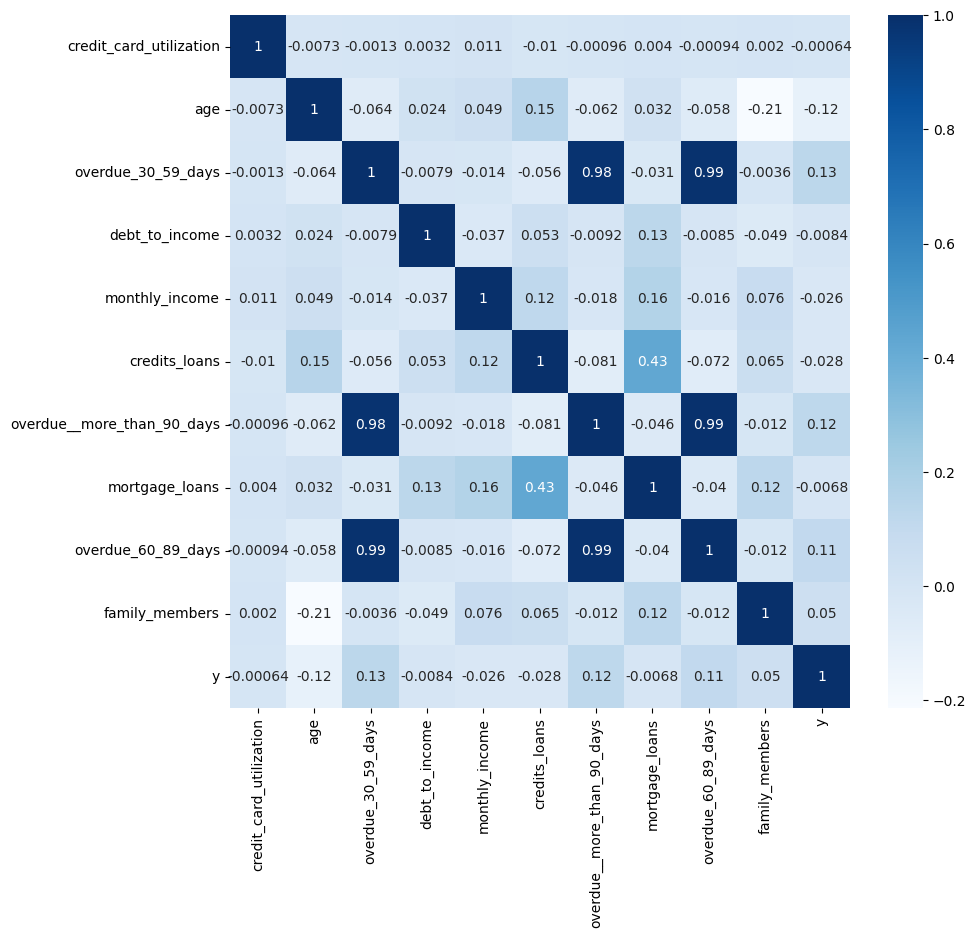

In [57]:
corr = x_train.corr()
plt.figure(figsize=(10,9))
sns.heatmap(corr, cmap="Blues",annot=True)
plt.show()

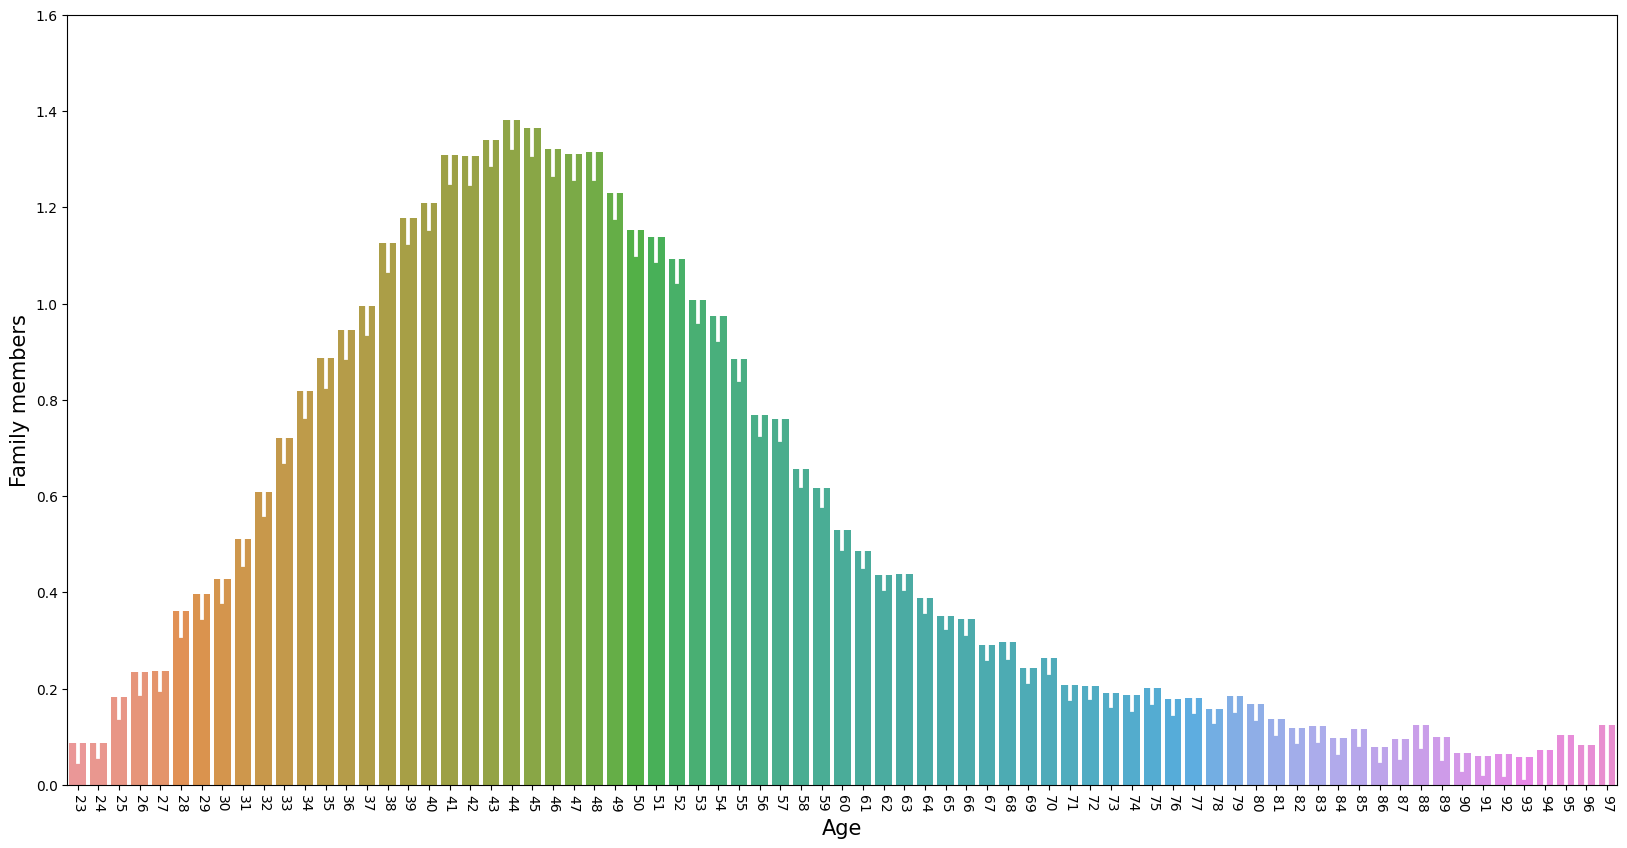

In [58]:
plt.figure(figsize=[20,10])
plt.ylim(0, 1.6)

col = sns.diverging_palette(0, 30, l=65, center="dark")
sns.set_palette(col)


ax1 = sns.barplot(data=x_train, x="age", y="family_members", errcolor= 'w')
ax1.set_xlabel("Age",fontsize=15)
ax1.set_ylabel("Family members",fontsize=15)
ax2 = ax1.set_xticklabels(ax1.get_xticklabels(),rotation=-90)


plt.xlim(1.5, 76.5);

In [59]:
for i in range(len(x_train.family_members)):
    if np.isnan(x_train.family_members.iloc[i]):
        x_train.family_members.iloc[i] = np.mean(x_train.family_members[x_train.age == x_train.age.iloc[i]])
x_train.head()

,credit_card_utilization,age,overdue_30_59_days,debt_to_income,monthly_income,credits_loans,overdue__more_than_90_days,mortgage_loans,overdue_60_89_days,family_members,y
0,0.000000,56,0,0.504328,6823.894458,9,0,1,0,5.0,0
1,0.170659,45,1,2.405860,356.580765,5,0,0,0,0.0,0
2,0.342176,75,1,0.445066,20349.895825,9,0,3,0,0.0,0
3,0.046219,50,0,0.814508,2894.368968,12,0,1,0,3.0,0
4,0.679556,58,0,0.390311,24833.227614,15,0,4,0,2.0,0


In [60]:

X = x_train.dropna()[['credits_loans', 'mortgage_loans']]
y = x_train.dropna()['monthly_income']
reg = sm.OLS(y, sm.add_constant(X)).fit()
x_train_cp = x_train[x_train.monthly_income.isna()]
x_train[x_train.monthly_income.isna()].monthly_income = reg.predict(sm.add_constant(x_train_cp[['credits_loans', 'mortgage_loans']]))

In [61]:
if 'debt' not in x_train.columns:
    x_train['debt'] = x_train.debt_to_income * x_train.monthly_income
    x_train.drop(columns=['debt_to_income'], inplace=True)

if 'overdue_30_59_days' in x_train.columns:
    x_train['overdue'] = 0
    x_train['overdue'] += x_train['overdue_30_59_days']
    x_train['overdue'] += x_train['overdue_60_89_days']*2
    x_train['overdue'] += x_train['overdue__more_than_90_days']*3

if 'overdue_30_59_days' in x_train.columns:
    x_train.drop(columns=['overdue_30_59_days', 'overdue_60_89_days', 'overdue__more_than_90_days'], inplace=True)

if 'family_members' in x_train.columns:
    x_train['monthly_income'] = x_train['monthly_income']/(x_train['family_members']+1)
    x_train.drop(columns=['family_members'], inplace=True)

In [62]:
x_train = x_train.dropna()
x, x_test, y, y_test = train_test_split(x_train.drop(columns = 'y'), x_train.y, test_size=0.33, random_state=1)

In [63]:
def FOR(y_true, y_pred):
    pred = pd.DataFrame({'pred': y_pred, 'true': y_true})
    result = pred[pred.pred == 0].true.sum()/(pred[pred.pred == 0].true.sum()+pred[pred.pred == 0].true.count() - pred[pred.pred == 0].true.sum())
    return result
def FPR(y_true, y_pred):
    pred = pd.DataFrame({'pred': y_pred, 'true': y_true})
    result = pred[pred.true == 1].pred.sum()/(pred[pred.true == 1].pred.sum()+pred[pred.pred == 0].true.count() - pred[pred.pred == 0].true.sum())
    return result
for_scorer = make_scorer(FOR, greater_is_better=False)
fpr_scorer = make_scorer(FPR, greater_is_better=False)

In [64]:
rf = RandomForestClassifier(max_depth=5, random_state=0,max_features= 3,n_estimators = 300)
for_cv = cross_val_score(rf, x, y, cv=5, scoring=for_scorer)
fpr_cv = cross_val_score(rf, x, y, cv=5, scoring=fpr_scorer)
print("Random forest percentage of defaulters accepted:", np.mean(abs(for_cv)))
print("Random forest percentage of non-defaulters denied:",np.mean(abs(fpr_cv)))

Random forest percentage of defaulters accepted: 0.06157209509954144
Random forest percentage of non-defaulters denied: 0.00894500437525476


In [65]:
x = x.reset_index(drop = True)
y = y.reset_index(drop = True)
def cv(mod, sampler):    
    res_fr, res_fpr = [], []
    for i in range(0, len(x), int(len(x)/5)):
        if i != 0:
            tst = x.iloc[range(prev, i)]
            trn = x.drop(index = range(prev, i))
            y_trn = y.drop(index = range(prev, i))
            if sampler != None:
                X_res, y_res = sampler.fit_resample(trn, y_trn)
            else:
                X_res, y_res = trn, y_trn
            mod = mod.fit(X_res, y_res)
            fr = FOR(y.iloc[range(prev, i)], mod.predict(tst))
            fpr = FPR(y.iloc[range(prev, i)], mod.predict(tst))
            res_fr.append(fr)
            res_fpr.append(fpr)
        prev = i
    return np.mean(res_fr), np.mean(res_fpr)

Random undersampling

In [66]:
rus = RandomUnderSampler(random_state = 1)
cv_res = cv(rf, rus)
print("Random forest percentage of defaulters accepted:", cv_res[0])
print("Random forest percentage of non-defaulters denied:",cv_res[1])

Random forest percentage of defaulters accepted: 0.02229382039349247
Random forest percentage of non-defaulters denied: 0.06865497975427493


Random oversampling

In [67]:
ros = RandomOverSampler(random_state = 1)
cv_res = cv(rf, ros)
print("Random forest percentage of defaulters accepted:", cv_res[0])
print("Random forest percentage of non-defaulters denied:",cv_res[1])

Random forest percentage of defaulters accepted: 0.023219929614328862
Random forest percentage of non-defaulters denied: 0.06640351091701985


In [68]:
smt = SMOTE(random_state = 1)
cv_res = cv(rf, smt)
print("Random forest percentage of defaulters accepted:", cv_res[0])
print("Random forest percentage of non-defaulters denied:",cv_res[1])

Random forest percentage of defaulters accepted: 0.02597217598935946
Random forest percentage of non-defaulters denied: 0.061573361761688705


Balanced Random Forest

In [69]:
brf = BalancedRandomForestClassifier(max_depth=5, max_features=5,  random_state=1, n_estimators = 300)
cv_res = cv(brf, None)
print("Random forest percentage of defaulters accepted:", cv_res[0])
print("Random forest percentage of non-defaulters denied:",cv_res[1])

Random forest percentage of defaulters accepted: 0.022104378087948698
Random forest percentage of non-defaulters denied: 0.06857395735700553


Profitability of the model

In [70]:
def ins(n, i):
    return n[:i] + ' ' + n[i:]
def bnumber(n):
    n = str(n)
    for i in range(len(n)-3, 0, -3):
        n = ins(n, i)
    return n

Operating profit without model

In [71]:
x = x.reset_index(drop = True)
y = y.reset_index(drop = True)
res = []
for i in range(0, len(x), int(len(x)/5)):
    if i != 0:
        tst = x.iloc[range(prev, i)]
        check = tst.copy()
        check['y'] = y.iloc[range(prev, i)]
        check['Op'] = 0
        check['Op'][check.y == 0] = 0.2*(check[check.y == 0].monthly_income)/2
        check['Op'][check.y == 1] = -1*(check[check.y == 1].monthly_income)/2
        res.append(check.Op.sum())
    prev = i
print('Operating profit before using model:', bnumber(round(np.mean(res))))

Operating profit before using model: 3 393 589


Operating profit with different models

In [72]:
x = x.reset_index(drop = True)
y = y.reset_index(drop = True)
def operating_profit_cv(mod, sampler):    
    res = []
    for i in range(0, len(x), int(len(x)/5)):
        if i != 0:
            tst = x.iloc[range(prev, i)]
            trn = x.drop(index = range(prev, i))
            y_trn = y.drop(index = range(prev, i))
            check = tst.copy()
            check['y'] = y.iloc[range(prev, i)]
            check['Op'] = 0
            check['Op'][check.y == 0] = 0.2*(check[check.y == 0].monthly_income)/2
            check['Op'][check.y == 1] = -1*(check[check.y == 1].monthly_income)/2
            if sampler != None:
                X_res, y_res = sampler.fit_resample(trn, y_trn)
            else:
                X_res, y_res = trn, y_trn
            mod = mod.fit(X_res, y_res)
            check['pred'] = mod.predict_proba(tst)[:,1]
            best = 0
            for j in np.arange(0.05, 0.91, 0.05):
                rev = check[check.pred <= j].Op.sum()
                if rev > best:
                    best = rev
                    bi = j
            res.append(best)
        prev = i
    return np.mean(res)

In [73]:
brf_rev = operating_profit_cv(brf, None)
rf_rev = operating_profit_cv(rf, rus)

In [74]:
print('Balanced Random Forest operating profit:', bnumber(round(brf_rev)))
print('Random Forest operating profit:', bnumber(round(rf_rev)))

Balanced Random Forest operating profit: 3 778 978
Random Forest operating profit: 3 768 180


In [75]:
lgbm = LGBMClassifier(random_state=1, max_depth=4, n_estimators=100)
cat = CatBoostClassifier(random_state=1, learning_rate = 0.05, iterations = 200, max_depth = 6, silent=True)
xgb = XGBClassifier(random_state=1, learning_rate = 0.05, max_depth = 2, min_child_weight = 6, eval_metric = 'logloss')
gbc = GradientBoostingClassifier(random_state=1, learning_rate = 0.003, max_depth = 3, n_estimators = 500, subsample = 0.4)

lgbm_rev = operating_profit_cv(lgbm, rus)
cat_rev = operating_profit_cv(cat, rus)
xgb_rev = operating_profit_cv(xgb, rus)
gbc_rev = operating_profit_cv(gbc, rus)

print('Light GBM operating profit:', bnumber(round(lgbm_rev)))
print('XGBoost operating profit:', bnumber(round(cat_rev)))
print('Gradient Boosting Classifier operating profit:', bnumber(round(xgb_rev)))
print('CatBoost operating profit:', bnumber(round(gbc_rev)))

Light GBM operating profit: 3 756 471
XGBoost operating profit: 3 767 588
Gradient Boosting Classifier operating profit: 3 769 980
CatBoost operating profit: 3 766 174


In [76]:
stc = StackingClassifier(estimators=[('rf',rf), ('gbc', gbc)], final_estimator=LogisticRegression())
stc2 = StackingClassifier(estimators=[('xgb', xgb), ('rf', rf), ('cat', cat)], final_estimator=LogisticRegression())
stc3 = StackingClassifier(estimators=[('brf',brf), ('rf', lgbm)], final_estimator=LogisticRegression())
stc4 = StackingClassifier(estimators=[('brf',brf), ('xgb', xgb), ('lgbm', lgbm)], final_estimator=LogisticRegression())
stc5 = StackingClassifier(estimators=[('brf',brf), ('rf', rf), ('cat', cat)], final_estimator=LogisticRegression())

stc_rev = operating_profit_cv(stc, rus)
stc2_rev = operating_profit_cv(stc2, rus)
stc3_rev = operating_profit_cv(stc3, None)
stc4_rev = operating_profit_cv(stc4, None)
stc5_rev = operating_profit_cv(stc5, None)

print('Stacking 1:', bnumber(round(stc_rev)))
print('Stacking 2:', bnumber(round(stc2_rev)))
print('Stacking 3:', bnumber(round(stc3_rev)))
print('Stacking 4:', bnumber(round(stc4_rev)))
print('Stacking 5:', bnumber(round(stc5_rev)))

Stacking 1: 3 772 312
Stacking 2: 3 769 629
Stacking 3: 3 779 963
Stacking 4: 3 779 627
Stacking 5: 3 784 322


Results

In [77]:
x = x.reset_index(drop = True)
y = y.reset_index(drop = True)
res = []
check = x_test.copy()
check['y'] = y_test
check['Op'] = 0
check['Op'][check.y == 0] = 0.2*(check[check.y == 0].monthly_income)/2
check['Op'][check.y == 1] = -1*(check[check.y == 1].monthly_income)/2
def_pro = round(check.Op.sum())
print('Operating profit before using model:', bnumber(def_pro))

Operating profit before using model: 8 490 463


In [78]:
def operating_profit_test(mod):
    check = x_test.copy()
    check['y'] = y_test
    check['Op'] = 0
    check['Op'][check.y == 0] = 0.2*(check[check.y == 0].monthly_income)/2
    check['Op'][check.y == 1] = -1*(check[check.y == 1].monthly_income)/2
    check['pred'] = mod.predict_proba(x_test)[:,1]
    best = 0
    for j in np.arange(0.05, 0.91, 0.05):
        rev = check[check.pred <= j].Op.sum()
        if rev > best:
            best = rev
            bi = j
    return best, bi

In [79]:
stc3 = StackingClassifier(estimators=[('brf',brf), ('rf', lgbm)], final_estimator=LogisticRegression()).fit(x, y)
stc4 = StackingClassifier(estimators=[('brf',brf), ('xgb', xgb), ('lgbm', lgbm)], final_estimator=LogisticRegression()).fit(x, y)
stc5 = StackingClassifier(estimators=[('brf',brf), ('rf', rf), ('cat', cat)], final_estimator=LogisticRegression()).fit(x, y)
brf = BalancedRandomForestClassifier(max_depth=5, max_features=5,  random_state=1, n_estimators = 300).fit(x, y)
rf = RandomForestClassifier(max_depth=5, max_features=5,  random_state=1, n_estimators = 300).fit(x, y)

In [80]:
stc3_rev = operating_profit_test(stc3)
stc4_rev = operating_profit_test(stc4)
stc5_rev = operating_profit_test(stc5)
brf_rev = operating_profit_test(brf)
rf_rev = operating_profit_test(rf)

In [81]:
def iip (best_res):
    return f'{round(((best_res/def_pro)-1)*100, 2)}%'

In [82]:
def FOR(model, thrs):
    cm = metrics.confusion_matrix(y_test, (model.predict_proba(x_test)[:,1] > thrs).astype(int))
    result = cm[1][0]/(cm[1][0]+cm[0][0])
    return result
def FPR(model, thrs):
    cm = metrics.confusion_matrix(y_test, (model.predict_proba(x_test)[:,1] > thrs).astype(int))
    result = cm[0][1]/(cm[0][1]+cm[0][0])
    return result

In [83]:
result = pd.DataFrame()
result['Model'] = ['Stacking BRF & LGBM', 'Stacking BRF & XGB & LGBM', 'Stacking BRF & RF & CAT', 'Random Forest', 'Balanced Random Forest']
result['Increase in operating profit'] = [iip(stc3_rev[0]), iip(stc4_rev[0]), iip(stc5_rev[0]), iip(rf_rev[0]), iip(brf_rev[0])]
result['Accepted defaulters'] = [FOR(stc3, stc3_rev[1]), FOR(stc4, stc4_rev[1]), FOR(stc5, stc5_rev[1]), FOR(rf, rf_rev[1]), FOR(brf, brf_rev[1])]
result['Denied non-defaulters'] = [FPR(stc3, stc3_rev[1]), FPR(stc4, stc4_rev[1]), FPR(stc5, stc5_rev[1]), FPR(rf, rf_rev[1]), FPR(brf, brf_rev[1])]
result['Accepted defaulters'] = (100*result['Accepted defaulters']).apply(lambda x: str(round(x, 2)) + '%')
result['Denied non-defaulters'] = (100*result['Denied non-defaulters']).apply(lambda x: str(round(x, 2)) + '%')
result.sort_values(by='Increase in operating profit', ignore_index=True, ascending=False)

,Model,Increase in operating profit,Accepted defaulters,Denied non-defaulters
0,Stacking BRF & RF & CAT,12.33%,4.09%,4.83%
1,Stacking BRF & XGB & LGBM,12.3%,4.06%,4.96%
2,Stacking BRF & LGBM,12.28%,4.06%,4.97%
3,Balanced Random Forest,12.06%,3.75%,6.3%
4,Random Forest,11.82%,4.19%,4.55%


<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=3c3ff880-8daf-4185-89ab-f1dd775ea1af' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>